# Monotonic Health Score

## Prerequisites

Add the Congrads package to the current Colab notebook environment and install it.

In [23]:
!pip install "congrads[examples]==0.3.0"

Import the necesary functions and classes.

In [24]:
import torch
import random
from collections import defaultdict
from matplotlib import pyplot as plt
from torch.nn import MSELoss, Module
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset
from IPython.display import clear_output

from congrads.callbacks.base import Callback, CallbackManager
from congrads.constraints.base import Constraint
from congrads.constraints.registry import (
    BinaryConstraint,
    PerGroupMonotonicityConstraint,
    RankedMonotonicityConstraint,
    ImplicationConstraint,
    ScalarConstraint,
)
from congrads.core.congradscore import CongradsCore
from congrads.datasets.registry import SectionedGaussians
from congrads.descriptor import Descriptor
from congrads.metrics import MetricManager
from congrads.networks.registry import MLPNetwork
from congrads.utils.utility import (
    CSVLogger,
    Seeder,
    ZeroLoss,
)

Define utility functions for plotting and other.

In [25]:
def get_all_data(subset):
    """Extract and stack all data from a PyTorch Dataset or Subset that returns dictionaries of tensors (with matching shapes).

    Args:
        subset (torch.utils.data.Subset or Dataset): Dataset or subset to extract from.

    Returns:
        dict[str, torch.Tensor]: Dictionary with each key stacked along dimension 0.
    """
    if isinstance(subset, Subset):
        dataset, indices = subset.dataset, subset.indices
        samples = [dataset[i] for i in indices]
    else:
        samples = [subset[i] for i in range(len(subset))]

    return {key: torch.stack([s[key] for s in samples]) for key in samples[0].keys()}


def plot_regression_epoch(
    descriptor: Descriptor,
    network: Module,
    loaders: tuple[DataLoader, DataLoader, DataLoader],
    device: torch.device,
):
    """Plot model predictions versus signal for training and test waveforms.

    Args:
        descriptor (Descriptor): Descriptor for selecting fields from datasets.
        network (Module): Neural network model.
        loaders (tuple): Tuple of (train_loader, val_loader, test_loader).
        device (torch.device): Device to run the model on (e.g., torch.device("cuda")).
    """
    train_loader, _, test_loader = loaders
    train_data = get_all_data(train_loader.dataset)
    test_data = get_all_data(test_loader.dataset)

    fig, ax_pred = plt.subplots(figsize=(6, 4))
    ax_signal = ax_pred.twinx()

    # Ensure prediction axis overlays signal axis
    ax_pred.set_zorder(ax_signal.get_zorder() + 1)
    ax_pred.patch.set_visible(False)

    network.eval()

    # Extract identifiers
    run_ids = descriptor.select("run_id", train_data)
    unique_ids = torch.unique(run_ids).cpu().numpy()
    run_ids_np = run_ids.cpu().numpy().flatten()

    cmap = plt.get_cmap("tab10")

    # Plot training signals (faint background)
    for i, waveform_id in enumerate(unique_ids):
        mask = run_ids_np == waveform_id
        time = descriptor.select("time", train_data)[mask].cpu().numpy()
        signal = descriptor.select("signal", train_data)[mask].cpu().numpy().flatten()

        ax_signal.scatter(
            time,
            signal,
            color=cmap(i % 10),
            alpha=0.2,
            s=5,
            label=f"Training signal {int(waveform_id)}",
        )

    # Prepare test waveform
    time_test = descriptor.select("time", test_data).cpu().numpy()
    signal_test = descriptor.select("signal", test_data)
    signal_test_np = signal_test.cpu().numpy().flatten()

    # Forward pass
    with torch.no_grad():
        preds = network({"input": signal_test.to(device)})["output"].cpu().numpy().flatten()

    # Plot test signal and prediction
    ax_signal.scatter(
        time_test,
        signal_test_np,
        color="black",
        alpha=0.4,
        s=10,
        label="Test signal",
    )

    ax_pred.plot(
        time_test,
        preds,
        color="red",
        linewidth=2,
        alpha=0.8,
        label="Test prediction",
    )

    # Titles and labels
    ax_pred.set_title("Model Predictions and Signal")
    ax_pred.set_xlabel("x")
    ax_pred.set_ylabel("Prediction", color="red")
    ax_signal.set_ylabel("Signal", color="gray")
    ax_pred.set_ylim(-0.1, 1.1)

    ax_pred.tick_params(axis="y", labelcolor="red")
    ax_signal.tick_params(axis="y", labelcolor="gray")

    # Merge legends and reorder so test entries appear together at the end
    lines_pred, labels_pred = ax_pred.get_legend_handles_labels()
    lines_sig, labels_sig = ax_signal.get_legend_handles_labels()

    # Combine
    lines = lines_pred + lines_sig
    labels = labels_pred + labels_sig

    # Sort so test set entries appear last
    sorted_pairs = sorted(
        zip(lines, labels, strict=False), key=lambda x: ("test" not in x[1].lower(), x[1].lower())
    )
    lines, labels = zip(*sorted_pairs, strict=False)

    ax_pred.legend(lines, labels, loc="best")

    fig.tight_layout()
    return ax_pred

def split_dataset(
    dataset: Dataset,
    loader_args: dict = None,
    train_loader_args: dict = None,
    valid_loader_args: dict = None,
    test_loader_args: dict = None,
    seed: int = 42,
    train_valid_split: float = 0.9,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    """Split dataset into train, validation, and test DataLoaders.

    One waveform (run) is randomly selected for testing, based on a seed.
    Validation samples come from the same runs as training (not unseen).
    """
    # Set default arguments for each loader
    train_loader_args = dict(loader_args or {}, **(train_loader_args or {}))
    valid_loader_args = dict(loader_args or {}, **(valid_loader_args or {}))
    test_loader_args = dict(loader_args or {}, **(test_loader_args or {}))

    # Group indices by run_identifier
    run_to_indices = defaultdict(list)
    for idx, sample in enumerate(dataset):
        run_id = int(sample["context"][-1].item())
        run_to_indices[run_id].append(idx)

    all_runs = list(run_to_indices.keys())

    # Pick a random run for testing
    random.seed(seed)
    test_run = random.choice(all_runs)
    test_runs = [test_run]
    train_runs = [r for r in all_runs if r not in test_runs]

    # Collect indices
    train_indices = [i for r in train_runs for i in run_to_indices[r]]
    test_indices = [i for r in test_runs for i in run_to_indices[r]]

    # Split train_indices into train/validation
    # (same runs, just different random shuffle)
    random.shuffle(train_indices)
    split_point = int(train_valid_split * len(train_indices))
    valid_indices = train_indices[split_point:]
    train_indices = train_indices[:split_point]

    # Create subsets
    train_data = Subset(dataset, train_indices)
    valid_data = Subset(dataset, valid_indices)
    test_data = Subset(dataset, test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_data, **train_loader_args)
    valid_loader = DataLoader(valid_data, **valid_loader_args)
    test_loader = DataLoader(test_data, **test_loader_args)

    return train_loader, valid_loader, test_loader


Before starting with the general training procedure, we fix the randomizer seeds and get the device on which we are training our model:



*   We have a built-in [Seeder class](https://congrads.readthedocs.io/en/latest/api.html#congrads.utils.Seeder) that will pseudo-randomly fix the seeds of random number generators, Numpy and PyTorch.
*   If there is a GPU available, use it. Otherwise fall back to CPU.



In [26]:
# Set seed for reproducibility
seeder = Seeder(base_seed=42)
seeder.set_reproducible()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Problem description

In this last example, the goal is to predict a "health score". This is a monotonically decreasing function that starts near 1 and ends near 0.

This problem is a simplification of a Remaining Useful Life (RUL) prediction, using synthetically generating data as shown on the figure below. An assumption we make here is that a difference in RUL must be a consequence of a change in input.

Mathematically:

* $x \in [0, 1]$, then $f(x) \ge 0$ `RUL is non-negative`
* $x \in [0, 1]$, then $f(x) \le 1$ `RUL is relative as it should work for runs of different length`
* $x \in [0, 0.1]$, then $f(x) \ge 0.9$ `RUL is large near the beginning`
* $x \in [0.9, 1]$, then $f(x) \le 0.1$ `RUL is small near the end`
* $x_1 \le x_2 \in [0, 1]$, then $f(x_1) \ge f(x_2)$ `RUL decays over time`


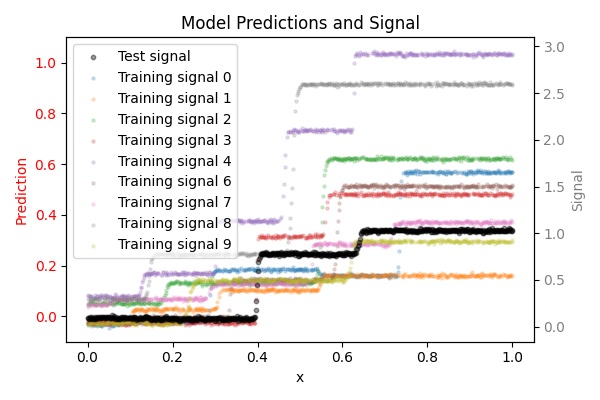

## Dataset

For this example we will use the built-in [SectionedGaussians dataset](https://congrads.readthedocs.io/en/latest/api.html#congrads.datasets.SectionedGaussians) with preconfigured settings, and we will split the dataset into training, validation and test sets such that 1 unseen full waveform is reserved to test the model.

In [27]:
# Load and preprocess data
sections = [
    {
        "range": (0.0, 0.40),
        "add_mean": 0.2,
        "std": 0.01,
        "max_splits": 1,
        "split_prob": 0.7,
        "mean_var": 0.6,
        "std_var": 0.0,
        "range_var": 0.9,
    },
    {
        "range": (0.40, 0.75),
        "add_mean": 1.8,
        "std": 0.01,
        "max_splits": 1,
        "split_prob": 0.4,
        "mean_var": 0.3,
        "std_var": 0.0,
        "range_var": 0.9,
    },
    {
        "range": (0.75, 1.0),
        "add_mean": 1.8,
        "std": 0.01,
        "max_splits": 0,
        "split_prob": 0.0,
        "mean_var": 0.4,
        "std_var": 0.0,
        "range_var": 0.9,
    },
]
dataset = SectionedGaussians(
    sections,
    n_samples=600,
    n_runs=10,
    seed=seeder.roll_seed(),
    blend_k=50,
)
loaders = split_dataset(
    dataset,
    loader_args={"batch_size": 100, "shuffle": True},
    valid_loader_args={"shuffle": False},
    test_loader_args={"shuffle": False},
    seed=seeder.roll_seed(),
    train_valid_split=0.8,
)

## Network

For this example we can again use the MLPNetwork, please configure it and push it to the current device.

In [28]:
# Instantiate an MLPNetworkWithSoftmax, configure the parameters
network = MLPNetwork(n_inputs=1, n_outputs=1, n_hidden_layers=4, hidden_dim=500)

# Push the network to the current device
network = network.to(device)

## Descriptor

The current descriptor setup is a little more complicated as the dataset and the problem are also more complex.

Our SectionedGaussians dataset returns a dictionary containing the required `input` and `target` keys, as well as an additional `context` key.

Each key contains data:

*   `input` holds the actual signal data to train the model on
*   `context` holds the time information, a precomputed energy derived from the signal as well as the run_ids which indicate the waveform identifier
* `target` holds a linear decreasing target score from 1 to 0


When training using constraints we do not use a loss, and as such the `target` data is not used. The constaints take over the responsability of guiding the network to a compliant solution.

When training without constraints we use an MSE loss between the predictions and this target output. The context data is not used in this case.

Please set up the descriptor and assign tags to the data:

*   `input` holds in column 0 the signal data
*   `context` holds in column 0, 1, 2 the time, energy and run_id data respectively
*   `target` holds in column 0 the target data



In [29]:
# Instantiate descriptor
descriptor = Descriptor()
descriptor.add("input", "signal", 0, constant=True)
descriptor.add("context", "time", 0, constant=True)
descriptor.add("context", "energy", 1, constant=True)
descriptor.add("context", "run_id", 2, constant=True)
descriptor.add("output", "score", 0)


## Constraints

With the help of the descriptor, we can easily reference certain parts of the neural network, and so we can now define our constraints.

We have [numerous pre-defined constraints](https://congrads.readthedocs.io/en/latest/api.html#module-congrads.constraints) available that allow a variety of options.

In this example, we want to build a network that can predict a health score between 1 and 0, indicating the remaining useful life (RUL) on a synthetic dataset.

The objectives:

* $x \in [0, 1]$, then $f(x) \ge 0$ `RUL is non-negative`
* $x \in [0, 1]$, then $f(x) \le 1$ `RUL is relative as it should work for runs of different length`
* $x \in [0, 0.1]$, then $f(x) \ge 0.9$ `RUL is large near the beginning`
* $x \in [0.9, 1]$, then $f(x) \le 0.1$ `RUL is small near the end`
* $x_1 \le x_2 \in [0, 1]$, then $f(x_1) \ge f(x_2)$ `RUL decays over time`


In [30]:
# Constraints definition
Constraint.descriptor = descriptor
Constraint.device = device
constraints = [
    ScalarConstraint("score", "<=", 1.05, rescale_factor=2.5),
    ScalarConstraint("score", ">=", -0.05, rescale_factor=2.5),
    ImplicationConstraint(
        head=ScalarConstraint("time", "<=", 0.1),
        body=ScalarConstraint("score", ">=", 0.95, rescale_factor=2.0),
    ),
    ImplicationConstraint(
        head=ScalarConstraint("time", ">=", 0.9),
        body=ScalarConstraint("score", "<=", 0.05, rescale_factor=2.0),
    ),
    PerGroupMonotonicityConstraint(
        base=RankedMonotonicityConstraint(
                "score",
                "time",
                direction="descending",
                rescale_factor_lower=1.50,
                rescale_factor_upper=1.75,
            ),
        tag_group="run_id"
    ),
    ImplicationConstraint(
        head=ScalarConstraint("time", "<=", 0.9),
        body=BinaryConstraint("score", ">=", "energy", rescale_factor=1.25),
    ),
]

/usr/local/lib/python3.12/dist-packages/congrads/constraints/base.py:216: UserWarning: Rescale factor for constraint score monotonically (ranked) descending by time is <= 1. The network will favor general loss over the constraint-adjusted loss. Is this intended behavior? Normally, the rescale factor should always be larger than 1.
  super().__init__({tag_prediction}, name, enforce, 1.0)
/usr/local/lib/python3.12/dist-packages/congrads/constraints/registry.py:895: UserWarning: Rescale factor for constraint score for each run_id monotonically (ranked) descending by time is <= 1. The network will favor general loss over the constraint-adjusted loss. Is this intended behavior? Normally, the rescale factor should always be larger than 1.
  super().__init__(base.tags, name, base.enforce, base.rescale_factor)


## Loss and optimizer

For this example, we do not need to use a loss function. The constraints will guide the network to a compliant solution. We therefore use the built-in [ZeroLoss](https://congrads.readthedocs.io/en/latest/api.html#congrads.utils.ZeroLoss) function as criterion, which returns 0 as loss effectively disabling it.

We will stick to the Adam optimizer for this example.

In [31]:
# Instantiate loss criterion
criterion = ZeroLoss()

# Instantiate optimizer
optimizer = Adam(network.parameters(), lr=0.001)

## Metric manager

To allow keeping track of constraint satisfaction rates for each individual constraints, as well as the losses and possibly other metrics, we instantiate a metric manager.

In [32]:
# Initialize metric manager
metric_manager = MetricManager()

## Core

The [CongradsCore](https://congrads.readthedocs.io/en/latest/api.html#congrads.core.CongradsCore) is the brain of the toolbox. It orchestrates the functionality of all previously created objects, integrating descriptors, constraints, and optimization strategies to perform constraint-guided gradient descent. Essentially, it manages the full training or evaluation pipeline: preparing input and output tensors, applying constraints, computing gradients, updating model parameters, and generating predictions in a coordinated manner.

First, we define callback that handles plotting per epoch.

Refer to the [Congrads documentation](https://congrads.readthedocs.io/en/latest/) for more info.

In [42]:
callback_manager = CallbackManager()

class PlottingCallback(Callback):
    def on_epoch_end(self, data, ctx):
        epoch = data["epoch"]
        if epoch % 10 == 0:
            clear_output(wait=True)
            print(f"Epoch: {epoch}")
            plot_regression_epoch(descriptor, network, loaders, device)
            plt.show()
            plt.close()

callback_manager.add(PlottingCallback())

<CallbackManager callbacks=['PlottingCallback'] ctx_keys=[]>

In [43]:
# Instantiate core
core = CongradsCore(
    descriptor=descriptor,
    constraints=constraints,
    dataloader_train=loaders[0],
    dataloader_valid=loaders[1],
    dataloader_test=loaders[2],
    network=network,
    criterion=criterion,
    optimizer=optimizer,
    metric_manager=metric_manager,
    callback_manager=callback_manager,
    device=device,
    enforce_all=True,
    disable_progress_bar_batch=True,
    disable_progress_bar_epoch=True
)

Finally, we can start training by running the `core.fit(...)` function. This function allows setting the maximum epochs and callback functions and will start the training process.

Epoch: 90


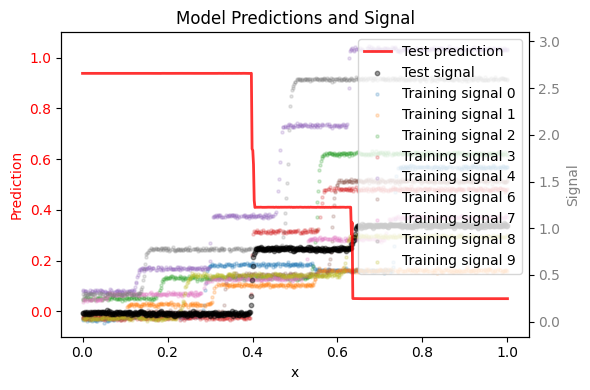

In [44]:
# Start training
core.fit(max_epochs=100)